In [40]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [41]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [42]:
data_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))

])

In [43]:
train_data=datasets.MNIST(
    root='/data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data=datasets.MNIST(
    root='/data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [44]:
train_data.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [45]:
from torch.utils.data import DataLoader
train_dataloader=DataLoader(train_data,batch_size=32,shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=32)

In [46]:
len(train_data),len(test_data)

(60000, 10000)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

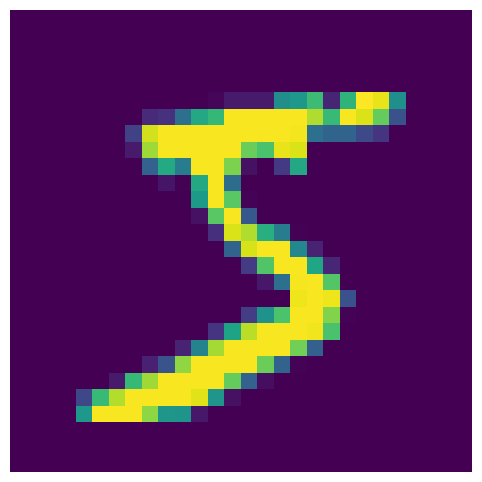

In [47]:
plt.figure(figsize=(10,6))
plt.imshow(train_data[0][0][0])
plt.axis("off")


In [55]:
from torch.nn.modules.dropout import Dropout
from torch import nn

class MnistClassifier(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.conv_block1=nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Dropout(0.2)
        )

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=128*14*14,out_features=10)
    )

  def forward(self,x):
    x=self.conv_block1(x)
    x=self.classifier(x)
    return x
torch.manual_seed(42)
model=MnistClassifier().to(device)

In [56]:
from torchsummary import summary
summ=summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
            Conv2d-3          [-1, 128, 28, 28]          73,856
         MaxPool2d-4          [-1, 128, 14, 14]               0
              ReLU-5          [-1, 128, 14, 14]               0
           Dropout-6          [-1, 128, 14, 14]               0
           Flatten-7                [-1, 25088]               0
            Linear-8                   [-1, 10]         250,890
Total params: 325,386
Trainable params: 325,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.30
Params size (MB): 1.24
Estimated Total Size (MB): 3.54
----------------------------------------------------------------


In [57]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [58]:
model.parameters()

<generator object Module.parameters at 0x7f77fbf37220>

In [59]:
input,label=next(iter(train_dataloader))
input,label=input.to(device),label.to(device)
input.shape

torch.Size([32, 1, 28, 28])

In [60]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)


        outputs = model(images)
        loss = criterion(outputs, labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Loss: {running_loss/len(train_dataloader):.4f} | "
          f"Train Acc: {train_acc*100:.2f}%")


Epoch 1/10 | Loss: 0.1189 | Train Acc: 96.42%
Epoch 2/10 | Loss: 0.0440 | Train Acc: 98.60%
Epoch 3/10 | Loss: 0.0321 | Train Acc: 98.96%
Epoch 4/10 | Loss: 0.0224 | Train Acc: 99.33%
Epoch 5/10 | Loss: 0.0165 | Train Acc: 99.46%
Epoch 6/10 | Loss: 0.0142 | Train Acc: 99.52%
Epoch 7/10 | Loss: 0.0099 | Train Acc: 99.64%
Epoch 8/10 | Loss: 0.0091 | Train Acc: 99.69%
Epoch 9/10 | Loss: 0.0075 | Train Acc: 99.73%
Epoch 10/10 | Loss: 0.0077 | Train Acc: 99.74%


In [61]:
test_input,test_label=next(iter(test_dataloader))


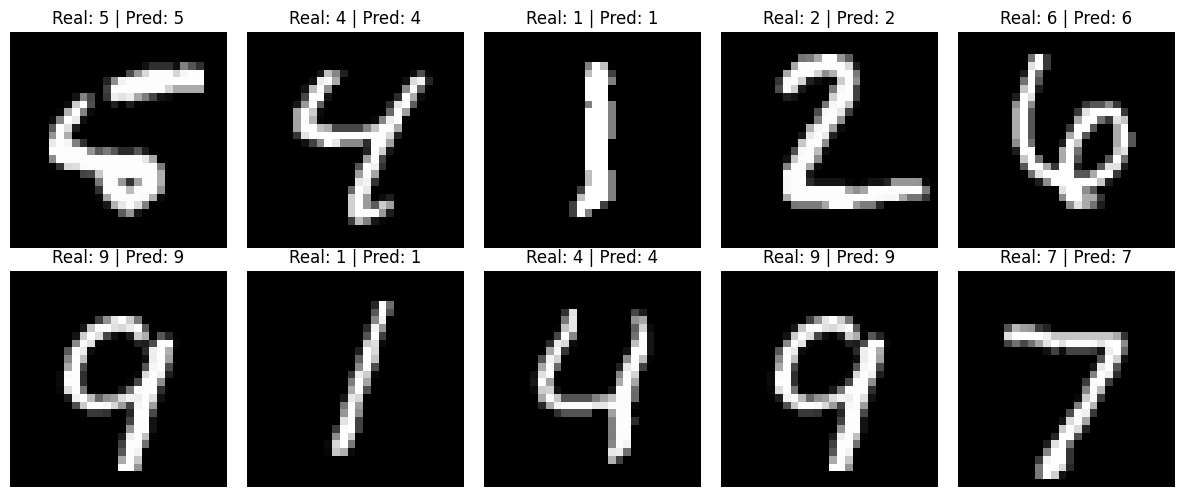

In [62]:
plt.figure(figsize=(12,5))

for i in range(10):
    with torch.inference_mode():
        n = np.random.randint(0, len(test_input))
        output = model(test_input[n].unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1)

        plt.subplot(2, 5, i+1)
        plt.imshow(test_input[n][0], cmap="gray")
        plt.title(f"Real: {test_label[n].item()} | Pred: {pred.item()}")
        plt.axis("off")

plt.tight_layout()
plt.show()


In [63]:
with torch.inference_mode():
  for i in range(10):
    for images,labels in test_dataloader:
      images,labels=images.to(device),labels.to(device)
      output=model(images)
      predicted=torch.argmax(output,dim=1)
      correct+=(predicted==labels).sum().item()
      total+=labels.size(0)
      print(f"Test Acc: {correct/total*100:.2f}%")

Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.74%
Test Acc: 99.73%
Test Acc: 99.73%
Test Acc: 99.73%
Test Acc: 99.73%
Test Acc: 99.73%
Test Acc: 99.73%
Test Acc: 99.73%
Test Acc: 99.73%
Test Acc: 99.73%
Test Acc: 99.73%
Test Acc: 99.73%
Test Acc: 99.72%
Test Acc: 99.72%
Test Acc: 99.72%
Test Acc: 99.72%
Test Acc: 99.72%
Test Acc: 99.72%
Test Acc: 99.72%
Test Acc: 99.72%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.71%
Test Acc: 99.7